<a href="https://colab.research.google.com/github/wallykop/iad-deep-learning/blob/master/sem_5_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 5: базовые архитектуры и дообучение предобученных сетей. 

В этом семинаре мы изучим внутреннее строение основных архитектур нейросетей для компьютерного зрения на примере задач классификации изображений, познакомимся с tensorflow dataset api а также попробуем дообучить нейросеть для новой задачи

## Model zoo

В задачах компьютерного зрения придумано много различных подходов. Мы остановимся на классификации изображений и покажем, что для новых задач можно не обучать нейосеть заново, и вместо этого лишь недолго **дообучить** уже обученную сеть.

## Imagenet

Imagenet -- это название датасета по классификации изображений на 1000 классов. Картинки, которые там используются -- цветные, $224 \times 224$. По состоянию на октябрь 2019 года наилучший результат принадлежит группе исследователей из Facebook AI и их подход описан в [статье](https://arxiv.org/pdf/1906.06423v2.pdf), и точность классификации составляет 86.5%.


Нейросети, способные на такой впечатляющий результат (который уже давно значительно лучше, чем способности человека), имеют сотни миллионов параметров, а на обучение таких моделей уходят не одни сутки работы на нескольких видеокартах. Ниже приводим таймлайн-обзор state-of-the-art моделей для классификации на Imagenet'e.

### AlexNet, ([Krizhevsky et al., 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks))

Бум нейросетей начался в 2012 году, когда группа исследователей из университета Торонто представила свёрточную архитектуру AlexNet. Иллюстрация приведена ниже.
![vgg19](https://github.com/hse-ds/iad-deep-learning/blob/master/sem5/alexnet.png?raw=1)

Основные отличия от уже рассмотренных моделей:
 * Обучение с аугментациями (намеренными выборочными искажениями исходных данных для увелечения размера выборки) и дропаутами во избежание переобучения.
 * Полносвязная "голова".
 * ReLU в качестве активации

### VGG, ([Simonyan & Zisserman, 2014](https://arxiv.org/abs/1409.1556))

Крайне похожая архитектура, где используется каскад свёрток $3 \times 3$ вместо свёрток с большим receptive field.

### GoogleNet (Inception), ([Szegedy et al. 2014](https://arxiv.org/abs/1409.4842))

Идея Inception заключается в не-Sequential архитектуре с конкатенацией блоков и несколькими выходами в функцию потерь.

![inception](https://github.com/hse-ds/iad-deep-learning/blob/master/sem5/inception.png?raw=1)

Сеть состоит из нескольких отдельных блоков со свёртками и пулингами. Каждый блок состоит из независимых друг от друга операций с входной картинкой, которые впоследствии конкатенируются на выходе.

![inception_base_block](https://github.com/hse-ds/iad-deep-learning/blob/master/sem5/inception_base_block.png?raw=1)

### ResNet ([He et al., 2015](https://arxiv.org/abs/1512.03385))

В этот раз исследователи решили увеличить число слоёв (теперь их более 100!). Однако для простой 100-слойной сети сущетсвует проблема -- при обучении градиент функции потерь на глубоких слоях "забывает" об исходной картинке совсем, и просто накидываение слоёв не приносит никакого результата. Для того, чтобы новые слои начинали приносить пользу, было предложено использовать **skip connections** (или по-другому **residual connections**)  -- связи начинают "перепрыгивать" операции.

![resnet](https://github.com/hse-ds/iad-deep-learning/blob/master/sem5/resnet.png?raw=1)

Пример одного свёрточного блока внутри сети выглядит так
![resblock](https://github.com/hse-ds/iad-deep-learning/blob/master/sem5/resblock.png?raw=1)

Теперь уже градиенты "запоминают" вход. Если в обычных архитектурах производная функции потерь

\begin{gather}
    y = \mathcal{F}(x)\\
    \cfrac{\partial L}{\partial x} = \cfrac{d\mathcal{F}}{d\mathcal x}\cdot \cfrac{\partial L}{\partial y}
\end{gather}
То теперь
\begin{gather}
    y = \mathcal{F}(x) + x\\
    \cfrac{\partial L}{\partial x} = \cfrac{d\mathcal{F}}{d\mathcal x}\cdot \cfrac{\partial L}{\partial y} + \cfrac{\partial L}{\partial y}
\end{gather}

в итоге градиент по входу очередного слоя содержит в себе градиент по выходу.

### MobileNet

Глубокие сети имеют важный недостаток: они тяжёлые и медленно работают. Важной инжереной задачей является ускорение работы нейросетей с сохранением качества моделей. В качестве решения такой задачи была предложена архитектура MobileNet. Там применён ряд трюков для сокращения числа параметров в дополнение к уже названным ухищрениям. 
**Замечание**. Мы не просим знать, как устроена эта сеть, равно как и не даём подробное описание. Мы используем её для примера в данном семинаре ввиду её скорости работы. Максимально подробно подход описан в [статье](https://arxiv.org/abs/1801.04381), также доступен её хороший [обзор](https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c)

## Зачем каждый раз обучать это заново?

И не нужно! Нейросети, которые используются для классификации изображений как правило имеют следующую структуру:

 1. "Тело" нейросети -- последовательности свёрток, пулингов и других ухищрений, которые работают над двумерными изображениями
 2. "Классификатор" -- один или несколько полносвязных слоёв, которые работают над вытянутой в вектор картинкой.
 
Смысл "тела" нейросети в том, что она умеет хорошо **извлекать признаки** из изображения (эти признаки как правило никак из интерпретируются человеком), а классификатор уже по этим признакам делает вердикт о принадлежности картинки к какому-нибудь классу. Ниже описанное на примере сети VGG19.

![vgg19](https://github.com/hse-ds/iad-deep-learning/blob/master/sem5/vgg19_example.jpg?raw=1)

Теперь мы подошли к идее fine-tuning'a. Мы предобучили нейросеть на большом датасете.

Попробуем пофайнтюнить? ;) 

В библиотеке `keras` реализовано множество архитектур, обученные веса которых можно скачать с официального сайта.

Мы рассмотрим два эксперимента:
 * обучение классификатора на признаках, извлечённых моделью.
 * Fine-tuning полученной итоговой нейросети.

Рассматривать будем классическую задачу классификации изображений кошек и собак. Воспользуемся библиотекой `tensorflow_datasets`. Для этого сначала скачаем датасет.

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf
tf.enable_eager_execution()

# Задаём разбиение на обучающую, валидационную и тестовую выборки.
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

In [0]:
IMG_SIZE = 160 # Именно такого размера картинки будут у нас

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

batch_size = 32
train_data = raw_train.map(format_example).batch(batch_size).repeat()
val_data = raw_validation.map(format_example).batch(batch_size).repeat()

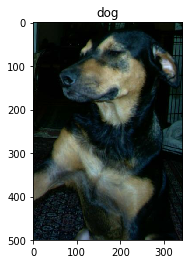

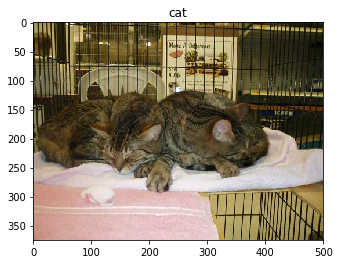

In [0]:
import matplotlib.pyplot as plt
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

Немного поясним происходящее. В современных версиях библиотеки tensorflow предусмотрен такой объект, как Dataset. Его смысл в том, что Вы можете использовать его как итератор по данным (пройтись в цикле `for item in dataset:`). При этом выбрать к этим данным преобразования (при помощи метода map) заранее или установить batch_size (при помощи метода batch). Такие же датасеты можно использовать в керасе в методе fit.

В `keras` реализовано множество моделей нейросетей. Мы остановимся на сети `MobileNetV2`, чтобы не тратить время на семинаре (поскольку остальные архитектуры очень долго обучаются).

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Создаём и загружаем веса модели
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Сначала мы разберём пример с обучением линейной головы поверх извлечённых сетью признаков. Так что поверх этой сети мы навесим классификационную "голову". 

In [0]:
# Заморозим исходную модель, чтобы по ней не считались градиенты
base_model.trainable = False

# Сделаем Global pooling, вытащив по одному пикселю из каждого канала
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

# Модель
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

# Компилируем
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Посмотрим, чему равно значение лосса и accuracy изначально.

In [0]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

initial_epochs = 10
steps_per_epoch = round(num_train)//batch_size
validation_steps = 20

loss0,accuracy0 = model.evaluate(val_data, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 6s 304ms/step - loss: 5.6148 - acc: 0.5406
initial loss: 5.61
initial accuracy: 0.54


Обучаем!

In [0]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,
                   steps_per_epoch=580,
                   validation_steps=20)

Train for 580 steps, validate for 20 steps
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


580/580 [==============================] - 63s 109ms/step - loss: 2.7254 - acc: 0.6752 - val_loss: 0.9802 - val_acc: 0.8687
Epoch 2/10
580/580 [==============================] - 61s 105ms/step - loss: 1.2029 - acc: 0.8366 - val_loss: 0.6452 - val_acc: 0.9234
Epoch 3/10
580/580 [==============================] - 61s 106ms/step - loss: 0.8275 - acc: 0.8871 - val_loss: 0.5608 - val_acc: 0.9406
Epoch 4/10
580/580 [==============================] - 62s 107ms/step - loss: 0.6791 - acc: 0.9076 - val_loss: 0.4298 - val_acc: 0.9453
Epoch 5/10
580/580 [==============================] - 61s 106ms/step - loss: 0.6009 - acc: 0.9180 - val_loss: 0.4314 - val_acc: 0.9469
Epoch 6/10
580/580 [==============================] - 61s 106ms/step - loss: 0.5504 - acc: 0.9252 - val_loss: 0.4019 - val_acc: 0.9563
Epoch 7/10
580/580 [==============================] - 61s 106ms/step - loss: 0.5223 - acc: 0.9311 - val_loss: 0.3577 - val_acc: 0.9594
Epoch 8/10
580/580 [==============================] - 62s 107ms/st

Как видим, очень высокой точности удаётся добиться всего при двух тысячах обучаемых параметров. Теперь попробуем обучить и остальные слои нашей сети для данной задачи.

In [0]:
base_model.trainable = True
model.compile(tf.train.AdamOptimizer(1e-4), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,
                   steps_per_epoch=580,
                   validation_steps=20)

Epoch 1/10


KeyboardInterrupt: ignored